# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [2]:
bs = 64

In [3]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [4]:
path = untar_data(URLs.PETS)/'images'

In [5]:
path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')

## Data augmentation

In [9]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [10]:
doc(get_transforms)

In [11]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [12]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [13]:
data = get_data(224, bs, 'zeros')

In [14]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category pomeranian, Category Maine_Coon, Category newfoundland, Category beagle, Category Bengal]...
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 500, 375), Image (3, 275, 183), Image (3, 375, 500), Image (3, 375, 500), Image (3, 333, 500)]...
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category Persian, Category Abyssinian, Category wheaten_terrier, Category Maine_Coon, Category Siamese]...
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 333, 500), Image (3, 500, 414), Image (3, 500, 333), Image (3, 500, 406), Image (3, 375, 500)]...
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Test: None

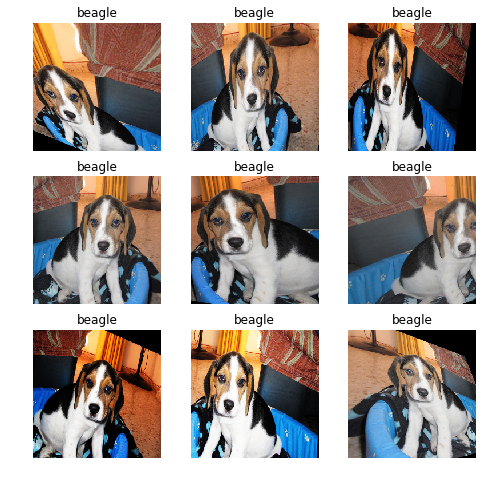

In [15]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [17]:
data.train_ds[3]

(Image (3, 224, 224), Category beagle)

In [18]:
data = get_data(224,bs)

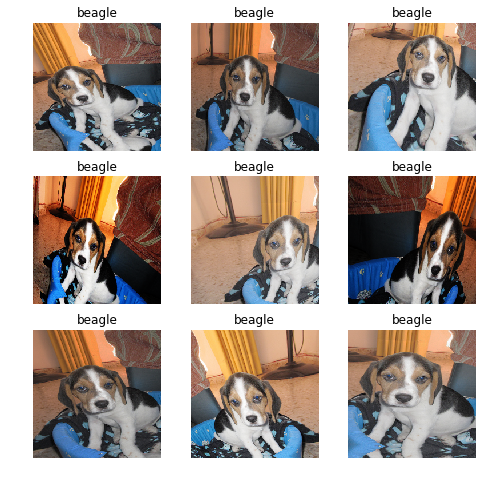

In [19]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [20]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [21]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.576064,1.353858,0.281461
2,1.540001,0.343779,0.087280
3,0.930592,0.277430,0.069012


In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.701125,0.286382,0.058863
2,0.672404,0.281254,0.061570


In [23]:
learn.save('224')

In [24]:
data = get_data(352,bs)
learn.data = data

In [25]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.603631,0.257993,0.048714
2,0.587403,0.259651,0.049391


In [26]:
learn.save('352')

## Convolution kernel

In [27]:
data = get_data(352,16)

In [30]:
data.batch_size

16

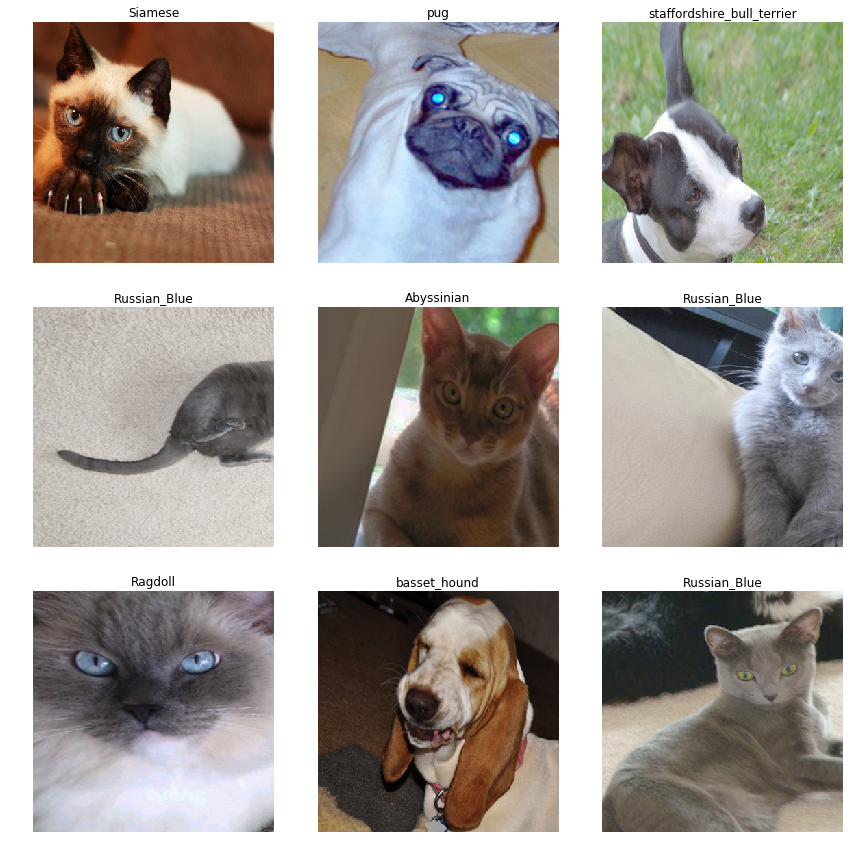

In [39]:
data.show_batch(3)

In [40]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Persian

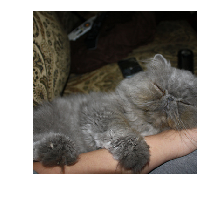

In [48]:
idx=0
x,y = data.valid_ds[idx]
x.show()
y
# data.valid_ds.y[idx]

In [44]:
data.valid_ds[1]

(Image (3, 352, 352), Category Abyssinian)

In [55]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [56]:
from fastai.callbacks.hooks import *

In [57]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [58]:
k.shape

torch.Size([1, 3, 3, 3])

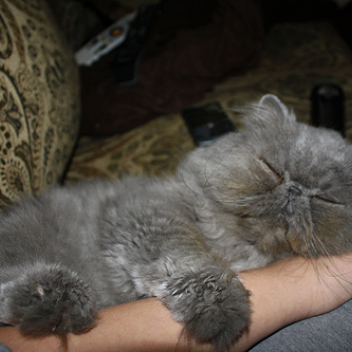

In [60]:
data.valid_ds[0][0]

In [61]:
data.valid_ds[0][0].data

tensor([[[0.1852, 0.1630, 0.2001,  ..., 0.0717, 0.0567, 0.0484],
         [0.2087, 0.1926, 0.1667,  ..., 0.0532, 0.0381, 0.0298],
         [0.2011, 0.1978, 0.1682,  ..., 0.0344, 0.0227, 0.0119],
         ...,
         [0.3190, 0.3268, 0.3391,  ..., 0.3173, 0.2359, 0.2077],
         [0.3192, 0.2969, 0.2887,  ..., 0.2879, 0.2670, 0.2210],
         [0.3246, 0.2849, 0.2628,  ..., 0.3237, 0.2349, 0.2791]],

        [[0.1612, 0.1358, 0.1766,  ..., 0.0678, 0.0492, 0.0438],
         [0.1814, 0.1652, 0.1394,  ..., 0.0527, 0.0377, 0.0265],
         [0.1736, 0.1701, 0.1372,  ..., 0.0344, 0.0227, 0.0115],
         ...,
         [0.3551, 0.3695, 0.3744,  ..., 0.3445, 0.2819, 0.2452],
         [0.3554, 0.3396, 0.3244,  ..., 0.3081, 0.2928, 0.2545],
         [0.3608, 0.3281, 0.3059,  ..., 0.3359, 0.2467, 0.3039]],

        [[0.0976, 0.0643, 0.0903,  ..., 0.0595, 0.0519, 0.0314],
         [0.1178, 0.0945, 0.0680,  ..., 0.0444, 0.0370, 0.0134],
         [0.1015, 0.1075, 0.0911,  ..., 0.0265, 0.0156, 0.

In [62]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

### It's three channels in a 352 x 352 image

In [63]:
t[None].shape

torch.Size([1, 3, 352, 352])

### We call t[None] to add another dimension so that we can call conv2d on it (which is expecting a 4d tensor since that is what we usually have because we have "stacked" 3x3x3 kernels). 

In [64]:
F

<module 'torch.nn.functional' from '/home/jupyter/.local/lib/python3.6/site-packages/torch/nn/functional.py'>

In [67]:
F.conv2d??

In [74]:
edge = F.conv2d(t[None], k)

In [75]:
edge

tensor([[[[-2.6899e-03,  2.5807e-02,  5.1115e-02,  ..., -5.9869e-02,
           -5.5865e-02, -5.4269e-02],
          [-4.4156e-02,  1.4668e-03,  6.4190e-02,  ..., -5.8112e-02,
           -5.1752e-02, -4.4635e-02],
          [ 4.1313e-03, -2.9499e-03,  3.7622e-02,  ..., -4.9668e-02,
           -3.6007e-02, -2.3107e-02],
          ...,
          [-2.0744e-03, -5.9243e-02, -5.2866e-02,  ..., -2.6537e-02,
           -1.3598e-02, -2.1352e-02],
          [-2.6158e-02, -9.8459e-02, -7.3457e-02,  ...,  1.1134e-01,
           -2.2172e-03, -5.6464e-02],
          [-3.9063e-02, -5.8447e-02, -1.1531e-02,  ...,  1.0110e-01,
           -6.3177e-02, -3.3886e-02]]]])

In [76]:
edge.shape

torch.Size([1, 1, 350, 350])

### We are at 350x350 now since we didn't add padding when we called conv2d.

In [77]:
edge[0]

tensor([[[-2.6899e-03,  2.5807e-02,  5.1115e-02,  ..., -5.9869e-02,
          -5.5865e-02, -5.4269e-02],
         [-4.4156e-02,  1.4668e-03,  6.4190e-02,  ..., -5.8112e-02,
          -5.1752e-02, -4.4635e-02],
         [ 4.1313e-03, -2.9499e-03,  3.7622e-02,  ..., -4.9668e-02,
          -3.6007e-02, -2.3107e-02],
         ...,
         [-2.0744e-03, -5.9243e-02, -5.2866e-02,  ..., -2.6537e-02,
          -1.3598e-02, -2.1352e-02],
         [-2.6158e-02, -9.8459e-02, -7.3457e-02,  ...,  1.1134e-01,
          -2.2172e-03, -5.6464e-02],
         [-3.9063e-02, -5.8447e-02, -1.1531e-02,  ...,  1.0110e-01,
          -6.3177e-02, -3.3886e-02]]])

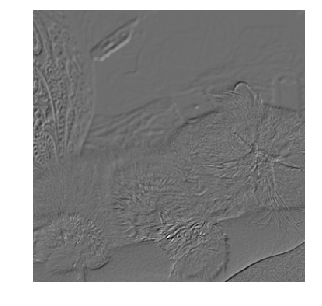

In [99]:
show_image(edge[0], figsize=(5,5));

In [86]:
k2 = tensor([
    [0.  ,0.,0.],
    [1.,1.,1.],
    [0.  ,0.   ,0.],
]).expand(1,3,3,3)/6

In [87]:
center = F.conv2d(t[None], k2)

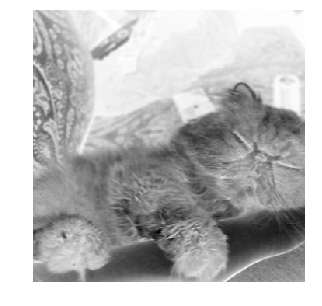

In [88]:
show_image(center[0], figsize=(5,5));

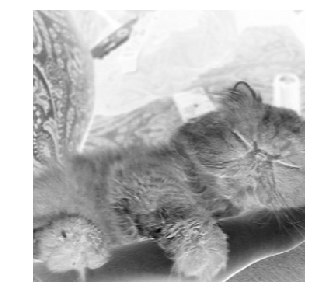

In [103]:
k3 = tensor([
    [0.  ,0.,0.],
    [-5/3,-5/3,-5/3],
    [10.  ,10.   ,10.],
]).expand(1,3,3,3)/6
bottom = F.conv2d(t[None], k3)
show_image(bottom[0], figsize=(5,5));

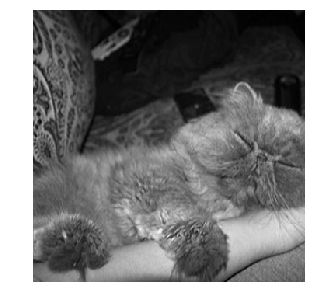

In [107]:
k4 = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [-5/3.  ,-5/3   ,1],
]).expand(1,3,3,3)/6
other = F.conv2d(t[None], k4)
show_image(other[0], figsize=(5,5));

In [83]:
data.c

37

In [84]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [85]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 176, 176]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 176, 176]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 176, 176]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 88, 88]     0          False     
______________________________________________________________________
Conv2d               [16, 64, 88, 88]     36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 88, 88]     128        True      
______________________________________________________________________
ReLU                 [16, 64, 88, 88]     0          False     
______________________________________________________________

## Heatmap

In [108]:
m = learn.model.eval();

In [109]:
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [110]:
learn.model.eval??

In [111]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [112]:
from fastai.callbacks.hooks import *

In [114]:
doc(hook_output)

##### By using "with", hook_output returns a hook and assigns it to hook_a and also calls an __exit__ function which removes the hook

In [115]:
y

Category Persian

In [117]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [118]:
hook_a,hook_g = hooked_backward()

In [122]:
hook_a.stored.shape

torch.Size([1, 512, 11, 11])

In [124]:
hook_a.stored[0].shape

torch.Size([512, 11, 11])

In [125]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

### We average across the 512 features so we can see what the average is across the image for the different images. For each patch of the images, we will see an average of the activations from all of the features

In [126]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [138]:
avg_acts

tensor([[1.0412, 1.0892, 0.6723, 0.4203, 0.2551, 0.1348, 0.1185, 0.1615, 0.3050,
         0.2952, 0.3413],
        [1.2820, 1.4120, 0.7642, 0.6424, 0.3402, 0.1551, 0.1787, 0.2834, 0.3163,
         0.3440, 0.3422],
        [1.0853, 1.1205, 0.5981, 0.3013, 0.2104, 0.1953, 0.3212, 0.5987, 0.7135,
         0.6894, 0.5508],
        [0.8370, 0.8065, 0.4631, 0.2860, 0.2623, 0.3044, 0.5698, 1.0864, 1.3018,
         1.2598, 1.0119],
        [0.6087, 0.5202, 0.3154, 0.3353, 0.3948, 0.5715, 0.9232, 1.4276, 1.7551,
         1.8988, 1.4195],
        [0.4492, 0.4541, 0.4216, 0.5741, 0.7275, 0.8934, 1.2147, 1.6436, 2.0116,
         2.2590, 1.7665],
        [0.5313, 0.7262, 0.8016, 1.0100, 1.1877, 1.2742, 1.3885, 1.6440, 2.0233,
         2.2937, 1.7754],
        [0.9297, 1.2220, 1.2440, 1.4985, 1.6509, 1.5907, 1.4435, 1.5086, 1.6987,
         1.9170, 1.4683],
        [1.0977, 1.4518, 1.3983, 1.6494, 1.8149, 1.6587, 1.4596, 1.3449, 1.2968,
         1.2354, 0.8743],
        [1.1835, 1.4646, 1.4203, 1.52

In [127]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

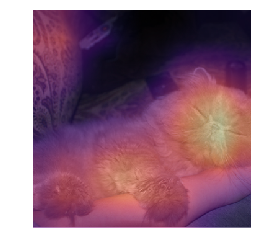

In [128]:
show_heatmap(avg_acts)

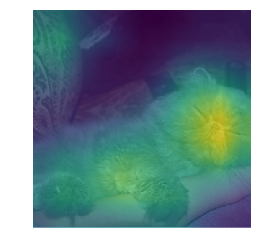

In [142]:
def show_heatmap2(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.7, extent=(0,352,352,0),
              interpolation='bilinear');
show_heatmap2(avg_acts)

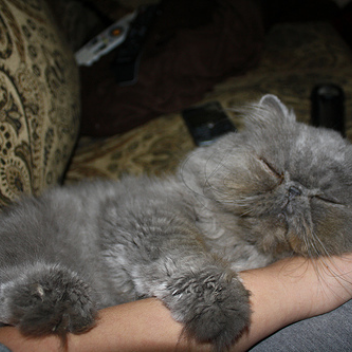

In [132]:
xb_im

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [143]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [144]:
mult = (acts*grad_chan[...,None,None]).mean(0)

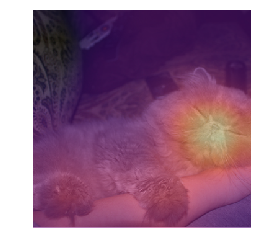

In [145]:
show_heatmap(mult)

In [146]:
fn = path/'../other/bulldog_maine.jpg'

In [148]:
path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')

In [147]:
x = open_image(fn); x

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/.fastai/data/oxford-iiit-pet/other/bulldog_maine.jpg'

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

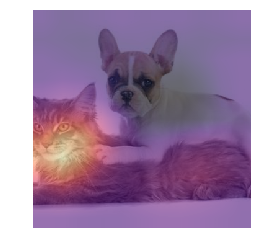

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'american_bulldog'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

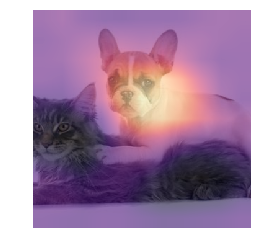

In [ ]:
show_heatmap(mult)

## fin